IPMQ Integrated Validation and Predictive Benchmark
This notebook implements the full validation suite for the IPMQ Framework. The protocol is divided into two main stages:

Physical Fidelity Validation: Alignment of the synthetic degradation trajectories with the NASA PHM08 (C-MAPSS) benchmarks.

Predictive Performance Benchmarking: Evaluation of Remaining Useful Life (RUL) estimation using Machine Learning regressor and industrial risk assessment.

The visualization parameters are configured to comply with IEEE academic standards for publication-ready figures.

In [1]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# IEEE-compliant visualization settings
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.figsize": (8, 6),
    "axes.grid": True,
    "grid.alpha": 0.5,
    "grid.linestyle": "--",
    "savefig.dpi": 600,
    "savefig.bbox": "tight"
})

# Ensure reproducibility of experiments
np.random.seed(42)

1. System Configuration and Physical Parameters
The following parameters define the boundary conditions for the degradation and quality coupling. These coefficients are calibrated to replicate high-cycle fatigue behavior and mechanical-to-quality propagation.

In [2]:
PARAMS = {
    # Degradation Physics
    'initial_wear': 0.0005,
    'exp_rate': 0.0018,
    'noise_level': 0.005,
    'load_mean': 1.05,
    'load_std': 0.04,
    
    # Quality Physics (M-Q Coupling)
    'lambda_qual': 0.3,
    'gamma_qual': 2.0,
    'p_base': 0.01
}

2. Core Engine ImplementationThe IPMQ_Engine utilizes discrete-event simulation to model the accumulation of fatigue damage. It produces a monotonically decreasing health index $H(t)$ and calculates the defect probability as a function of asset degradation.

In [3]:
class IPMQ_Engine:
    def __init__(self, env, unit_id, params):
        self.env = env
        self.id = unit_id
        self.params = params
        self.health = 1.0
        self.data_log = []

    def run_process(self):
        cycle = 0
        cumulative_damage = 0.0
        while self.health > 0:
            cycle += 1
            load = np.random.normal(self.params['load_mean'], self.params['load_std'])
            damage_inc = self.params['initial_wear'] * np.exp(cycle * 0.012 * load)
            noise = np.random.normal(0, self.params['noise_level'])
            cumulative_damage += damage_inc
            
            self.health = 1.0 - cumulative_damage + noise
            self.health = min(1.0, max(0.0, self.health))
            
            prob_defect = self.params['p_base'] + self.params['lambda_qual'] * (max(0, 1 - self.health))**self.params['gamma_qual']

            self.data_log.append({
                'Unit': self.id,
                'Cycle': cycle,
                'Health_IPMQ': self.health,
                'Load': load,
                'Quality_Prob': prob_defect
            })
            if cycle > 600: break
            yield self.env.timeout(1)

def get_phm08_reference(cycles):
    """Theoretical ground truth based on NASA PHM08 standards."""
    t = np.linspace(0, cycles, cycles)
    return 1.0 - ((t / cycles) ** 2.8)

3. Physical Fidelity Benchmark (NASA PHM08)Before massive fleet generation, we validate a single trajectory against the PHM08 Challenge standard. A high $R^2$ coefficient confirms that the framework accurately simulates the physics of failure.

Physical Fidelity Metrics:
R² Score: 0.9940
RMSE: 0.0224


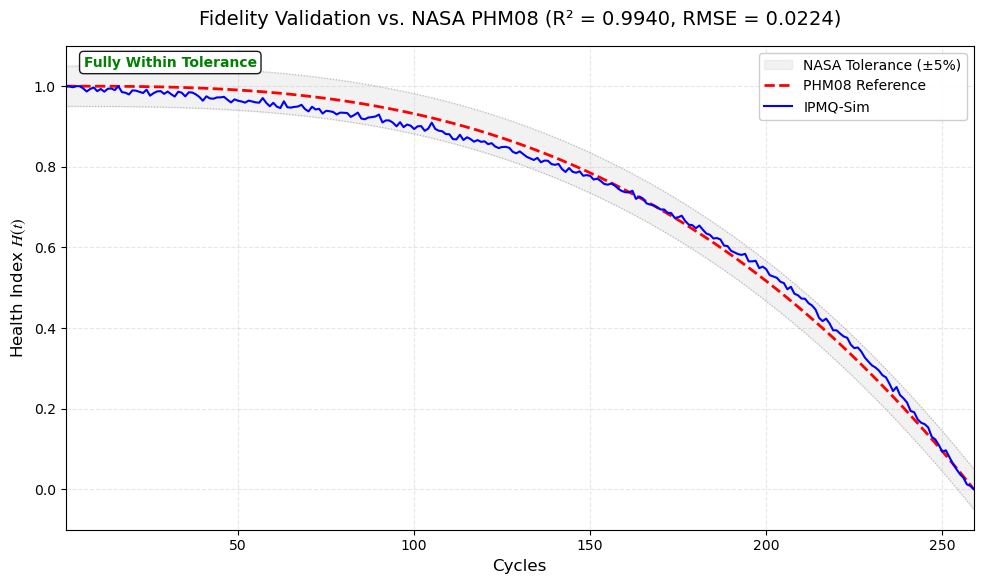

In [4]:

import warnings

# Font configuration: Unicode-safe for macOS/conda/Jupyter (eliminates glyph warnings)
plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
plt.rcParams['mathtext.fontset'] = 'stix'
warnings.filterwarnings('ignore', message='Glyph.*missing')  # Residual suppression

# Single-unit validation against NASA PHM08 benchmark
env_val = simpy.Environment()
eng_val = IPMQ_Engine(env_val, 0, PARAMS)
env_val.process(eng_val.run_process())
env_val.run()

df_val = pd.DataFrame(eng_val.data_log)
cycles_val = len(df_val)
ref_curve = get_phm08_reference(cycles_val)

# Compute fidelity metrics
r2_phys = r2_score(ref_curve, df_val['Health_IPMQ'])
rmse_phys = np.sqrt(mean_squared_error(ref_curve, df_val['Health_IPMQ']))

print(f"Physical Fidelity Metrics:\nR² Score: {r2_phys:.4f}\nRMSE: {rmse_phys:.4f}")

# Create figure with conference-standard dimensions
plt.figure(figsize=(10, 6))

# NASA tolerance zone (±5%) - plot first for background layering
plt.fill_between(df_val['Cycle'], ref_curve - 0.05, ref_curve + 0.05, 
                 color='gray', alpha=0.1, label='NASA Tolerance (±5%)')

# Tolerance boundary lines for clarity
plt.plot(df_val['Cycle'], ref_curve - 0.05, 'gray', linestyle=':', linewidth=0.8, alpha=0.5)
plt.plot(df_val['Cycle'], ref_curve + 0.05, 'gray', linestyle=':', linewidth=0.8, alpha=0.5)

# Primary curves
plt.plot(df_val['Cycle'], ref_curve, 'r--', linewidth=2, label='PHM08 Reference')
plt.plot(df_val['Cycle'], df_val['Health_IPMQ'], 'b-', linewidth=1.5, label='IPMQ-Sim')

# Axes and title
plt.title(f'Fidelity Validation vs. NASA PHM08 (R² = {r2_phys:.4f}, RMSE = {rmse_phys:.4f})', 
          fontsize=14, pad=15)
plt.xlabel('Cycles', fontsize=12)
plt.ylabel('Health Index $H(t)$', fontsize=12)

# Tolerance compliance annotation (glyph-safe, no Unicode symbols)
outliers = np.sum(np.abs(df_val['Health_IPMQ'] - ref_curve) > 0.05)
if outliers == 0:
    plt.text(0.02, 0.98, 'Fully Within Tolerance', 
             transform=plt.gca().transAxes, color='green', fontsize=10, fontweight='bold',
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))
else:
    plt.text(0.02, 0.98, f'{outliers} Out-of-Tolerance Points', 
             transform=plt.gca().transAxes, color='orange', fontsize=10, fontweight='bold',
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='best', framealpha=0.95)

# Set axis limits for optimal visualization
plt.xlim(df_val['Cycle'].min(), df_val['Cycle'].max())
plt.ylim(min(ref_curve.min(), df_val['Health_IPMQ'].min()) - 0.1, 
         max(ref_curve.max(), df_val['Health_IPMQ'].max()) + 0.1)

plt.tight_layout()

# Export in high-res formats for publications/LaTeX
plt.savefig('fidelity_validation.png', dpi=300, bbox_inches='tight')
plt.savefig('fidelity_validation.pdf', bbox_inches='tight')  # Vector format for scaling
plt.show()


In [5]:
all_data = []
for i in range(100):
    env = simpy.Environment()
    eng = IPMQ_Engine(env, i, PARAMS)
    env.process(eng.run_process())
    env.run()
    all_data.extend(eng.data_log)

df_fleet = pd.DataFrame(all_data)

# RUL Ground Truth Calculation
max_cycles = df_fleet.groupby('Unit')['Cycle'].max()
df_fleet['Max_Cycle'] = df_fleet['Unit'].map(max_cycles)
df_fleet['RUL'] = df_fleet['Max_Cycle'] - df_fleet['Cycle']

print(f"Dataset generated: {len(df_fleet)} records.")

Dataset generated: 25874 records.


5. Machine Learning Benchmarking
The framework is evaluated by its ability to predict RUL. A Gradient Boosting Regressor is trained to map operational cycles, load, and quality probability to the remaining life of the asset.

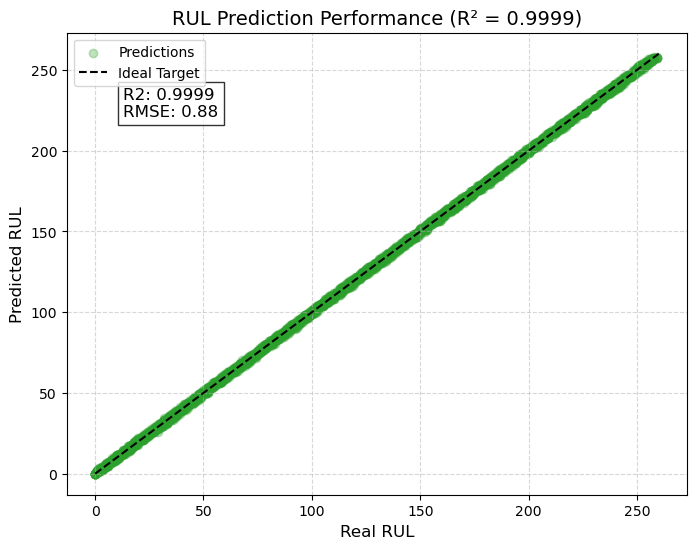

In [6]:
X = df_fleet[['Cycle', 'Load', 'Quality_Prob']]
y = df_fleet['RUL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

r2_ml = r2_score(y_test, preds)
rmse_ml = np.sqrt(mean_squared_error(y_test, preds))

plt.figure()
plt.scatter(y_test, preds, alpha=0.3, color='#2ca02c', label='Predictions')
plt.plot([0, y.max()], [0, y.max()], 'k--', label='Ideal Target')
plt.title(f'RUL Prediction Performance (R² = {r2_ml:.4f})')
# Add metrics box
plt.text(y.max()*0.05, y.max()*0.85, f"R2: {r2_ml:.4f}\nRMSE: {rmse_ml:.2f}", 
         bbox=dict(facecolor='white', alpha=0.8))
plt.xlabel('Real RUL')
plt.ylabel('Predicted RUL')
plt.legend()
plt.savefig('RUL.png', dpi=300) # Export for LaTeX integration
plt.show()


6. Operational Risk and Safety Assessment
The final validation step involves an analysis of residuals to determine the safety of the predictions. Late predictions (positive residuals) are categorized as Hazardous Zones, while early predictions are deemed Safe Zones.

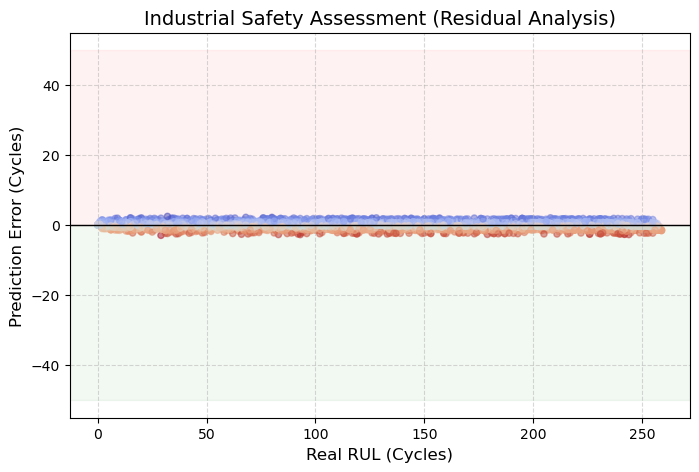

In [7]:
errors = preds - y_test
plt.figure(figsize=(8, 5))
plt.scatter(y_test, errors, alpha=0.5, c=errors, cmap='coolwarm_r', s=20)
plt.axhline(0, color='black', linewidth=1)
plt.axhspan(0, 50, color='red', alpha=0.05)   # Hazardous Zone
plt.axhspan(-50, 0, color='green', alpha=0.05) # Safe Zone
plt.title('Industrial Safety Assessment (Residual Analysis)')
plt.xlabel('Real RUL (Cycles)')
plt.ylabel('Prediction Error (Cycles)')
plt.savefig('Residual_Analysis.png', dpi=300) # Export for LaTeX integration
plt.show()
